In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random 

from target_distribution import target_distribution
from utils.distributions import normal_dist
from utils.plot import plot_all_targets, plot_comparison
from models.flows import Planar, FirstLayer
from models.model import PlanarFlow

In [2]:
manual_seed = 24605 
if manual_seed is None:
    manual_seed = random.randint(1, 100000)
random.seed(manual_seed)
torch.manual_seed(manual_seed)
print(manual_seed)

24605


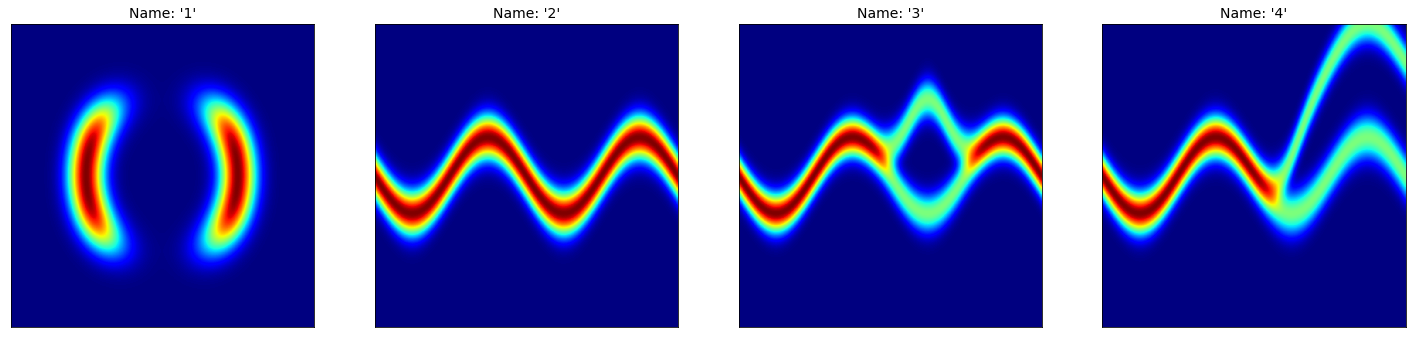

In [3]:
#Plot the four test energy functions of Table 1.
plot_all_targets()

In [4]:
#Loss function (KL divergence)

def binary_loss_function(model, target_distr, z_0, z_k, log_det_jacobians):
               
    log_p_zk = - target_distr(z_k) # ln p(z_k): unnormalized target distribution 
    log_q_z0 = normal_dist(z_0, mean=torch.zeros(2), logvar=torch.zeros(2), dim=1) 

    kl = torch.sum(log_q_z0 - log_p_zk) - torch.sum(log_det_jacobians) #sum over batches      
    kl = kl / z_0.size(0)
    
    return kl 

In [5]:
#Training function 

def train(model, opt, num_batches, batch_size, target, flow_length):

    model.train()
    density = target_distribution(target)
    
    for  batch_num in range(1, num_batches + 1):
        
        #Get batch from N(0,I)
        batch = torch.zeros(size=(batch_size, 2)).normal_(mean=0, std=1) 
        # Pass batch through flow
        zk, log_jacobians = model(batch)
        # Compute loss under target distribution.
        loss = binary_loss_function(model, density, batch, zk, log_jacobians) 
        
        #Optimization step, Backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss = loss.item()
        
        if batch_num%50000 == 0:
            print('Batch_num: {:3d}/ {:3d} loss: {:.4f}'.format(batch_num, num_batches, loss))
    
    filename = 'logs/planar' + f"{flow_length}flows_target{target}"
    plot_comparison(model, target, flow_length, filename)
            
    return loss

In [6]:
def run(target, flow_type, num_flows, learnable_affine, num_batches, batch_size, lr):

    print("Density appoximation for test energy function " + target)
    loss = []
    i = 0 
    for K in num_flows:
        flow_length = K
        print("Number of flows:")
        print(flow_length)
                       
        #Initializations
        if flow_type == "planar":
            model = PlanarFlow(flow_length, z_size, learnable_affine)
            
       #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, momentum=0.9)

        #Training for the target distribution
        train_loss = train(model, optimizer, num_batches[i], batch_size, target, flow_length)
        
        filename = 'results/' + f"{flow_length}flows_{num_batches[i]}_iterations_target{target}"
        plot_comparison(model, target, flow_length, filename, not_end = False)
        loss.append(train_loss) 
        i = i +1 
        
        #save the model
        json_dir = 'results/' + f"model_target{target_distr}_{flow_length}flows.pt"
        print("Saving data at: " + json_dir)
        torch.save(model.state_dict(), json_dir)
        
        #to load model
        #model = PlanarFlow(flow_length, z_size, learnable_affine)
        #model.load_state_dict(torch.load(json_dir))
        
    json_dir_loss = 'results/' + f"loss_curve_target{target_distr}.pt"
    torch.save(loss, json_dir_loss)
    print("Saving loss curve at: " + json_dir_loss)   
    #to load loss curve
    #loss_curve = torch.load(json_dir_loss)
        
    return model, loss   

Density appoximation for test energy function 3
Number of flows:
2
Batch_num: 50000/ 100000 loss: -0.4713
Batch_num: 100000/ 100000 loss: -0.4187
Saving data at: results/model_target3_2flows.pt
Number of flows:
8
Batch_num: 50000/ 400000 loss: -1.0401
Batch_num: 100000/ 400000 loss: -0.9430
Batch_num: 150000/ 400000 loss: -1.0637
Batch_num: 200000/ 400000 loss: -0.9890
Batch_num: 250000/ 400000 loss: -1.0424
Batch_num: 300000/ 400000 loss: -1.0307
Batch_num: 350000/ 400000 loss: -1.1009
Batch_num: 400000/ 400000 loss: -1.0416
Saving data at: results/model_target3_8flows.pt
Number of flows:
32
Batch_num: 50000/ 450000 loss: -1.7288
Batch_num: 100000/ 450000 loss: -1.8437
Batch_num: 150000/ 450000 loss: -1.8280
Batch_num: 200000/ 450000 loss: -1.7584
Batch_num: 250000/ 450000 loss: -1.8441
Batch_num: 300000/ 450000 loss: -1.8907
Batch_num: 350000/ 450000 loss: -1.8447
Batch_num: 400000/ 450000 loss: -1.8653
Batch_num: 450000/ 450000 loss: -1.8489
Saving data at: results/model_target3_32f

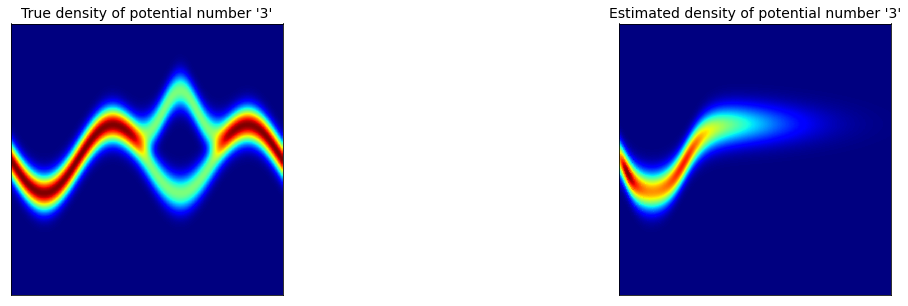

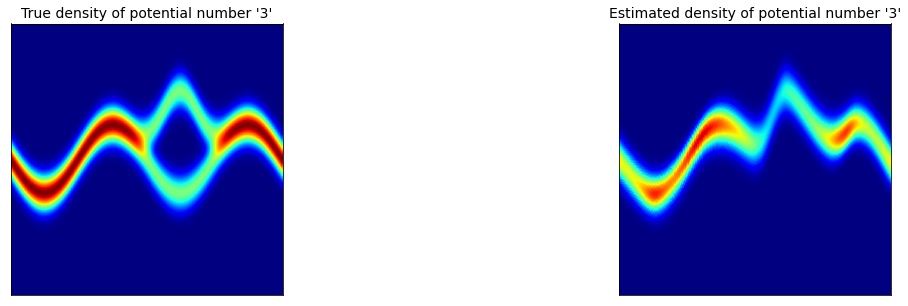

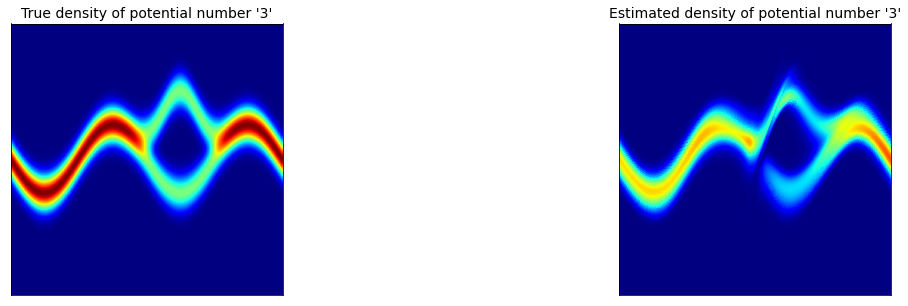

In [7]:
#Target 3 seed 24605 0.1
num_batches = [1000*100, 1000*400, 1000*450]

z_size = 2
batch_size = 128   
num_flows = [2,8,32]
learning_rate = 1e-4
learnable_affine = True

target_distr = "3"  
model3, loss3 = run(target_distr, "planar", num_flows, learnable_affine, num_batches, batch_size, lr = learning_rate)

Density appoximation for test energy function 4
Number of flows:
2
Batch_num: 50000/ 50000 loss: -0.4685
Saving data at: results/model_target4_2flows.pt
Number of flows:
8
Batch_num: 50000/ 300000 loss: -1.1300
Batch_num: 100000/ 300000 loss: -1.1437
Batch_num: 150000/ 300000 loss: -1.0741
Batch_num: 200000/ 300000 loss: -1.2221
Batch_num: 250000/ 300000 loss: -1.2374
Batch_num: 300000/ 300000 loss: -1.2796
Saving data at: results/model_target4_8flows.pt
Number of flows:
32
Batch_num: 50000/ 300000 loss: -1.2729
Batch_num: 100000/ 300000 loss: -1.3912
Batch_num: 150000/ 300000 loss: -1.4685
Batch_num: 200000/ 300000 loss: -1.4922
Batch_num: 250000/ 300000 loss: -1.5857
Batch_num: 300000/ 300000 loss: -1.6481
Saving data at: results/model_target4_32flows.pt
Saving loss curve at: results/loss_curve_target4.pt


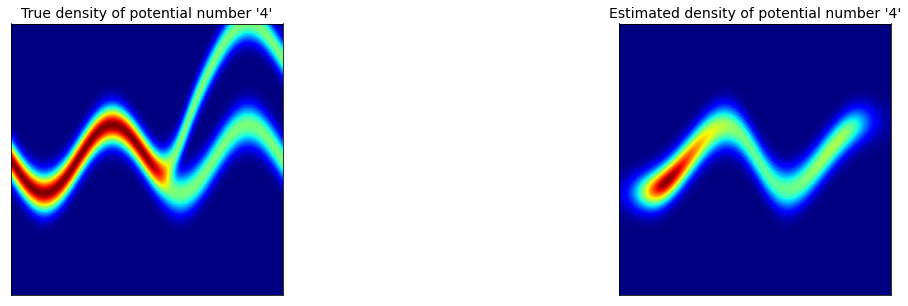

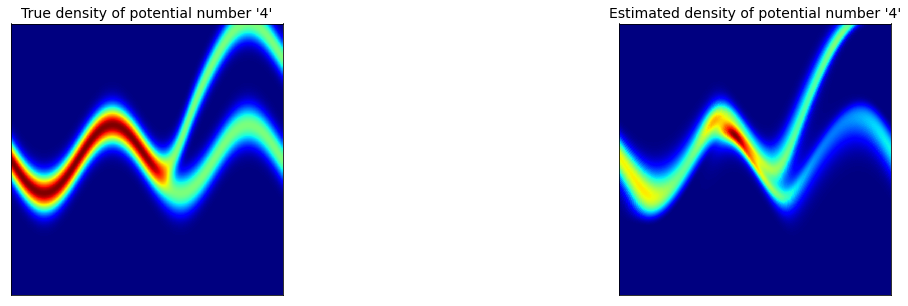

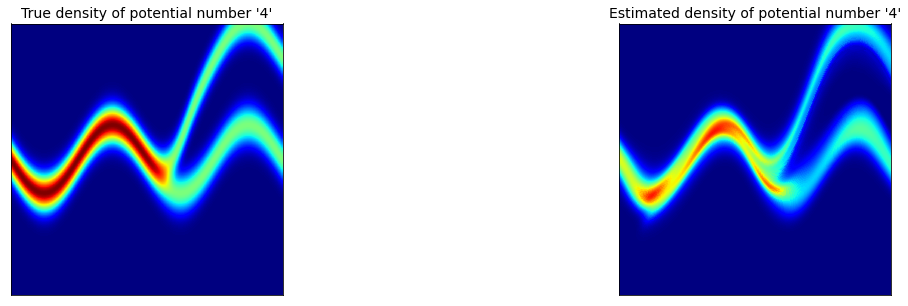

In [8]:
#Target 4 seed 24605 0.1
num_batches = [1000*50, 1000*300, 1000*300]

target_distr = "4"  
model4, loss4 = run(target_distr, "planar", num_flows, learnable_affine, num_batches, batch_size, lr = learning_rate)

Density appoximation for test energy function 2
Number of flows:
2
Batch_num: 50000/ 50000 loss: -0.1183
Saving data at: results/model_target2_2flows.pt
Number of flows:
8
Batch_num: 50000/ 200000 loss: -1.0256
Batch_num: 100000/ 200000 loss: -0.9962
Batch_num: 150000/ 200000 loss: -1.0348
Batch_num: 200000/ 200000 loss: -1.0656
Saving data at: results/model_target2_8flows.pt
Number of flows:
32
Batch_num: 50000/ 200000 loss: -1.0735
Batch_num: 100000/ 200000 loss: -1.3427
Batch_num: 150000/ 200000 loss: -1.3688
Batch_num: 200000/ 200000 loss: -1.4017
Saving data at: results/model_target2_32flows.pt
Saving loss curve at: results/loss_curve_target2.pt


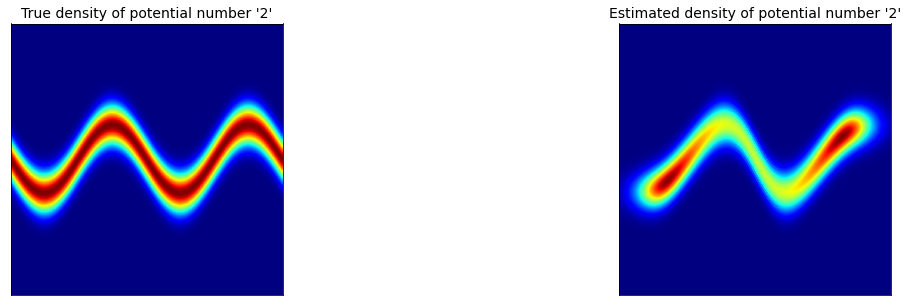

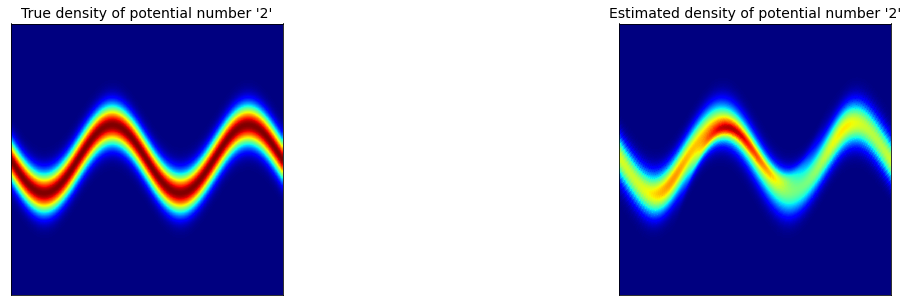

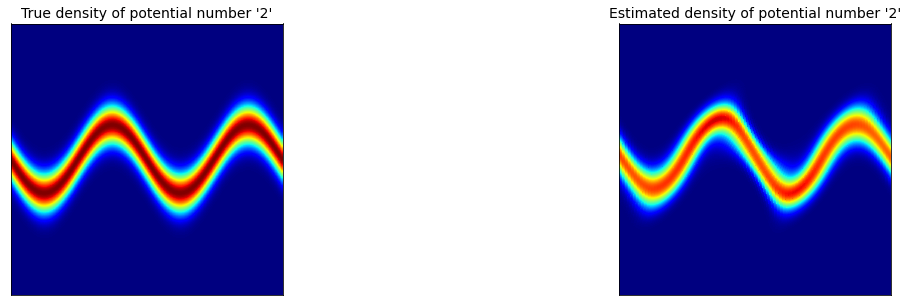

In [9]:
#Target 2
num_batches = [1000*50, 1000*200, 1000*200]

target_distr = "2"  
model2, loss2 = run(target_distr, "planar", num_flows, learnable_affine,num_batches, batch_size, lr = learning_rate)

Density appoximation for test energy function 1
Number of flows:
2
Batch_num: 50000/ 50000 loss: 0.0857
Saving data at: results/model_target1_2flows.pt
Number of flows:
8
Batch_num: 50000/ 200000 loss: -0.0296
Batch_num: 100000/ 200000 loss: 0.0423
Batch_num: 150000/ 200000 loss: -0.0407
Batch_num: 200000/ 200000 loss: -0.0066
Saving data at: results/model_target1_8flows.pt
Number of flows:
32
Batch_num: 50000/ 200000 loss: -0.0377
Batch_num: 100000/ 200000 loss: -0.0207
Batch_num: 150000/ 200000 loss: -0.0348
Batch_num: 200000/ 200000 loss: -0.0520
Saving data at: results/model_target1_32flows.pt
Saving loss curve at: results/loss_curve_target1.pt


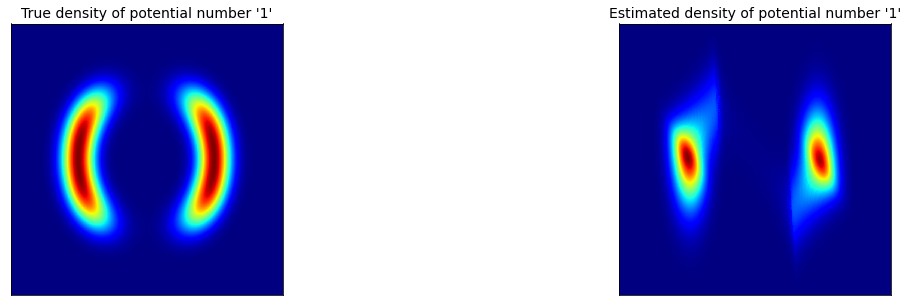

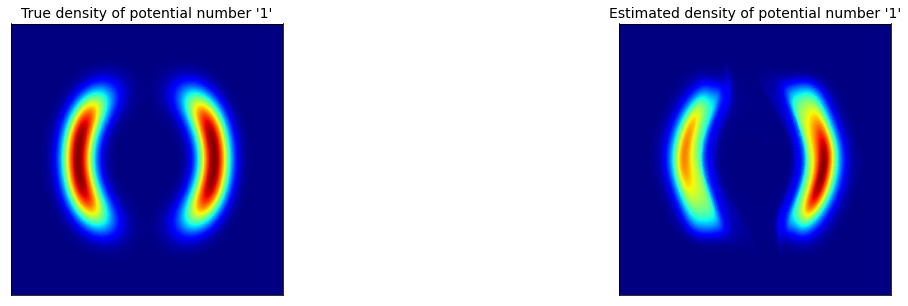

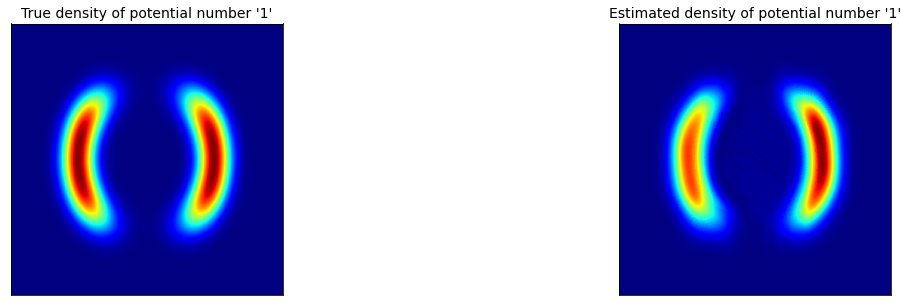

In [10]:
# Define parameters
z_size = 2
num_batches = [1000*50, 1000*200, 1000*200]

#Target 1 
target_distr = "1"  
model1, loss1 = run(target_distr, "planar", num_flows, learnable_affine, num_batches, batch_size, lr = learning_rate)